In [1]:
from sklearn.datasets import load_svmlight_file

import lightgbm as lgb
import numpy as np
import pandas as pd
import pickle
import time
import csv
import re
import os

from sklearn.model_selection import KFold
from itertools import chain
from glob import glob


%matplotlib inline

In [2]:
def read_data():
    columns = ['context_id','context_2','context_1','context_0','reply_id','reply','label','confidence']

    test_df = pd.read_csv("./data/final.tsv", sep="\t", header=None, quoting=csv.QUOTE_NONE)
    train_df = pd.read_csv("./data/train.tsv", sep="\t", header=None, quoting=csv.QUOTE_NONE)

    train_df = train_df.fillna("")
    test_df = test_df.fillna("")

    test_df.columns = columns[:-2]
    train_df.columns = columns
    
    return train_df, test_df

train_df, test_df = read_data()

nl = []
for l in train_df['label'].tolist():
    if l == 'good':
        nl.append(1)
    elif l == 'neutral':
        nl.append(0.5)
    elif l == 'bad':
        nl.append(0)
        
y_train = np.array(nl)

train_weights = np.array(train_df['confidence'])

In [3]:
def load_internal_features(dpath):
    preds = [(f, pickle.load(open(f, "rb"))) for f in glob(dpath)]
    feats = []
    for p,n in zip(preds, glob(dpath)):
        if os.path.basename(n) in blacklist:
            print("skipping {}".format(n))
            continue
        print("loading {}".format(n))
        
        feats.append(make_oof_features(p))
    return feats

def load_external_features(dpath):
    feats = []
    for f in glob(dpath):
        if os.path.basename(f) in blacklist:
            print("skipping {}".format(f))
            continue
        print("loading {}".format(f))
        feature = pickle.load(open(f,"rb"))
        ftr_name = ["{}_{}".format(f.split("/")[-1], i) for i in range(feature[0].shape[1])]
        feature.append(ftr_name)
        feats.append(feature)
    return feats

def make_oof_features(ppack):

    pname, ppack = ppack
    pname = pname.split('/')[-1]
    
    pdict = {}
    for fold in ppack[1]:
        for prdrow, idrow in zip(*fold):
            pdict[idrow] = prdrow
    
    pred_mtx = np.array([pdict[rid] for rid in range(len(pdict))])
    ts_pred_mtx = np.mean(ppack[2], axis=0)
    ftr_names = ["{}_{}".format(pname, i) for i in range(pred_mtx.shape[1])]
            
    return pred_mtx, ts_pred_mtx, ftr_names

def build_submission(predictions, sub_name):

    prr = predictions
    
    last = None
    bufs = []
    buf = []
    for ii, im_id in enumerate(test_df['context_id']):
        if im_id!=last and buf:
            bufs.append(buf)
            buf = []
        buf.append(ii)
        last = im_id
    bufs.append(buf)

    predicted_ranks = []
    for buf in bufs:
        pred_batch = prr[np.array(buf)]
        predicted_ranks += list(np.argsort(pred_batch)[::-1])

    test_df['reply_id'] = predicted_ranks
    test_df[['context_id', 'reply_id']].to_csv(os.path.join("./submissions/", sub_name), 
                                               index=False, header=None, sep='\t')

def getbasenames(fnames):
    return list(map(os.path.basename, fnames))

In [4]:
blacklist = []

intf = load_internal_features("./features/supervised/*")
extf = load_external_features("./features/unsupervised/*")

allft = intf+extf

tr_ftr = np.hstack([i[0] for i in allft])
ts_ftr = np.hstack([i[1] for i in allft])

feature_names = list(chain.from_iterable([i[2] for i in allft]))

print("Loaded {} features".format(tr_ftr.shape[1]))

loading ./features/supervised/rus_fasttext.pkl
loading ./features/unsupervised/tfv_1.pkl
loading ./features/unsupervised/wms_stops.pkl
loading ./features/unsupervised/wmd_fasttext.pkl
loading ./features/unsupervised/tfv_2.pkl
loading ./features/unsupervised/markdown.pkl
loading ./features/unsupervised/avw_my_ppc.pkl
loading ./features/unsupervised/tfv_0.pkl
loading ./features/unsupervised/wms_nostops.pkl
loading ./features/unsupervised/wmd_my_ppc_lemma.pkl
loading ./features/unsupervised/lengths.pkl
loading ./features/unsupervised/wmd_my_ppc.pkl
loading ./features/unsupervised/wmd_araneum.pkl
loading ./features/unsupervised/avw_my_ppc_lemma.pkl
loading ./features/unsupervised/avw_fasttext.pkl
loading ./features/unsupervised/fuzz.pkl
loading ./features/unsupervised/rogue.pkl
loading ./features/unsupervised/avw_araneum.pkl
Loaded 70 features


In [7]:
alfpreds = []
alscores = []

jobs = 8

for i in range(10):

    folder = KFold(n_splits=8, shuffle=True, random_state=34+i)

    fpreds = []
    scores = []

    for rnd, (train_ids, val_ids) in enumerate(folder.split(np.array(list(range(len(tr_ftr)))))):
        gbm = lgb.LGBMRegressor(max_depth=6, min_split_gain=0.15, colsample_bytree=0.8, n_jobs=jobs, num_leaves=64)
        gbm.fit(tr_ftr[train_ids], y_train[train_ids], eval_set=[(tr_ftr[val_ids], y_train[val_ids])],
            early_stopping_rounds=5, verbose=False, feature_name=feature_names, 
                sample_weight=train_weights[train_ids], eval_sample_weight=[train_weights[val_ids]])

        gbm = lgb.LGBMRegressor(max_depth=6, min_split_gain=0.15, colsample_bytree=0.8, num_leaves=64,
                                n_estimators=gbm.best_iteration_, n_jobs=jobs)
        gbm.fit(tr_ftr[train_ids], y_train[train_ids], eval_set=[(tr_ftr[val_ids], y_train[val_ids])],
            early_stopping_rounds=5, verbose=False, feature_name=feature_names,
               sample_weight=train_weights[train_ids], eval_sample_weight=[train_weights[val_ids]])

        fpreds.append(gbm.predict(ts_ftr))
        scores.append(gbm.best_score_['valid_0']['l2'])
        print("Round {} score: {}".format(rnd+1, scores[-1]))

    print(np.mean(scores))
    alscores.append(np.mean(scores))
    alfpreds.append(np.mean(fpreds, axis=0))

Round 1 score: 0.17734843036264003
Round 2 score: 0.1790937925131869
Round 3 score: 0.1776715284545205
Round 4 score: 0.1764275906955965
Round 5 score: 0.17814848461704072
Round 6 score: 0.17683824231074818
Round 7 score: 0.17740902674660802
Round 8 score: 0.17741741124192503
0.17754431336778323


In [9]:
build_submission(np.mean(alfpreds, axis=0), "submission.csv")

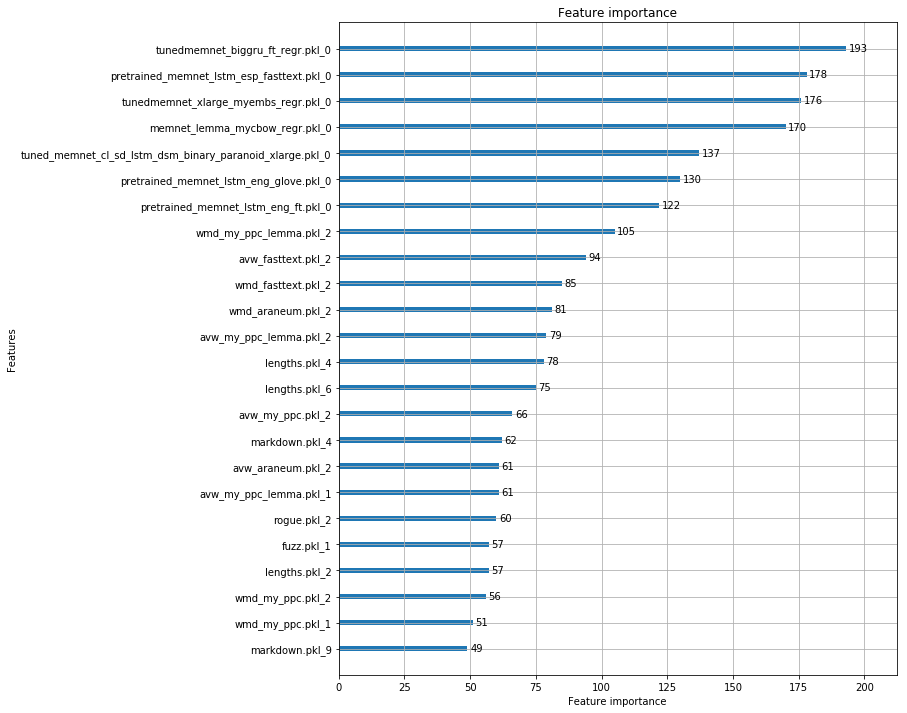

In [8]:
lgb.plot_importance(gbm, figsize=(10,12), max_num_features=24)